#TODO:
- Read the muscimol field in ReadAnimalData


This notebook analyses data from Bpod.

Tested on output of protocol 'Two_Alternative_Choice'

In [71]:
%load_ext autoreload
%autoreload 2
from utils import custom_functions, plot_utils, Lapse_model
import os
import sys
sys.path.append("../") # go to parent 
import Bpod_OE_Francesca.utils.load_nested_structs as load_ns
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import math
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def ReadAnimalData(GeneralDirectory, AnimalID, BpodProtocol, printout = True):
    # Reads all data from one animal and one protocol
    
    # Initialize return lists
    ExperimentFiles = [] # to store experiment names
    ExperimentData = [] # to store the dictionaries
    ntrialsDistribution = [] # to visualize the distribution of the number of trials
    Protocols = [] # store the protocols
    Stimulations = [] # store the stimulated protocols
    counter = 0
    for file in glob.glob(GeneralDirectory+AnimalID + BpodProtocol +'Session Data/*.mat'):
        # Read data
        data = load_ns.loadmat(file)
        
        # if that session is empty skip it:
        if not 'nTrials' in data['SessionData']:
            continue
        
        ntrials = data['SessionData']['nTrials'] # this sometimes fails if the session is empty

        ExperimentFiles.append(file)
        # Parse the settings of the trials
        trial_raw_events = data['SessionData']['TrialSettings']
        for trial_num, trial in enumerate(trial_raw_events):
            trial_raw_events[trial_num] = load_ns._todict(trial)
        data['SessionData']['TrialSettings'] = trial_raw_events

        # Get info for the settings from the first trial
        try:
            protocol = trial_raw_events[0]['GUIMeta']['TrainingLevel']['String'][
                trial_raw_events[0]['GUI']['TrainingLevel'] - 1]
        except:
            protocol = 'Unknown'

        try:
            stimulation = trial_raw_events[0]['GUIMeta']['OptoStim']['String'][
                trial_raw_events[0]['GUI']['OptoStim'] - 1]
        except:
            stimulation = 'unknown'
        
        if printout:
            print('{}: {}, {} trials on protocol {}, stimulation {}'.format(counter, ntpath.basename(file), ntrials, protocol, stimulation))
        
        ntrialsDistribution.append(ntrials)
        Protocols.append(protocol)
        Stimulations.append(stimulation)

        # as RawEvents.Trial is a cell array of structs in MATLAB, we have to loop through the array and convert the structs to dicts
        trial_raw_events = data['SessionData']['RawEvents']['Trial']
        for trial_num, trial in enumerate(trial_raw_events):
            trial_raw_events[trial_num] = load_ns._todict(trial)
        data['SessionData']['RawEvents']['Trial'] = trial_raw_events

        # Save the data in a list
        ExperimentData.append(data)
        counter+=1
        
    return ExperimentFiles, ExperimentData, ntrialsDistribution, Protocols, Stimulations

In [2]:
# Select animal to analyze
AnimalID = 'Ot02'
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/'

# Create out directory if it does not exist
outputDir = GeneralDirectory + AnimalID + BpodProtocol + 'Data_Analysis/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

0: Ot02_Two_Alternative_Choice_20190312_164621.mat, 11 trials on protocol Habituation, stimulation NoStimulation
1: Ot02_Two_Alternative_Choice_20190312_165924.mat, 315 trials on protocol Habituation, stimulation NoStimulation
2: Ot02_Two_Alternative_Choice_20190313_173434.mat, 247 trials on protocol Visual, stimulation NoStimulation
3: Ot02_Two_Alternative_Choice_20190313_180723.mat, 240 trials on protocol Visual, stimulation NoStimulation
4: Ot02_Two_Alternative_Choice_20190314_174418.mat, 732 trials on protocol Visual, stimulation NoStimulation
5: Ot02_Two_Alternative_Choice_20190315_165543.mat, 112 trials on protocol Visual, stimulation NoStimulation
6: Ot02_Two_Alternative_Choice_20190318_165938.mat, 714 trials on protocol Visual, stimulation NoStimulation
7: Ot02_Two_Alternative_Choice_20190319_150614.mat, 282 trials on protocol Visual, stimulation Right
8: Ot02_Two_Alternative_Choice_20190319_173145.mat, 96 trials on protocol Visual, stimulation Right
9: Ot02_Two_Alternative_Cho

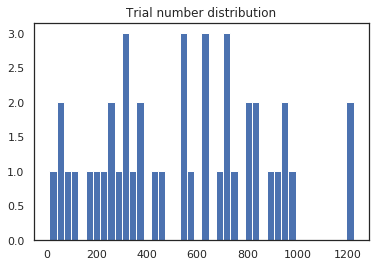

In [24]:
# Read data
ExperimentFiles, ExperimentData,\
ntrialsDistribution, Protocols, Stimulations =\
ReadAnimalData(GeneralDirectory, AnimalID, BpodProtocol, printout = True)

# get the date and time from the files
ExperimentTimes = custom_functions.ParseForTimes(ExperimentFiles)
ExperimentDates = custom_functions.ParseForDates(ExperimentFiles)
# Transform to e.g. Feb20
ExperimentDatesPretty = custom_functions.MakeDatesPretty(ExperimentTimes)

# plot number of trials    
plt.hist(ntrialsDistribution, bins=len(ExperimentFiles))
plt.title('Trial number distribution')
plt.show()

In [25]:
# Clean data
# Remove those experiments fow which a proper time has not been found (old ones that are missing a lot of variables)
# Or those with low number of trials
idxToRemove = custom_functions.identifyIdx(ExperimentTimes, ntrialsDistribution, 30)

for idx in idxToRemove:
    print('deleting data for {} with {} trials'.format(ntpath.basename(ExperimentFiles[idx]), ntrialsDistribution[idx]))
    ExperimentData.pop(idx)
    ExperimentDates.pop(idx)
    ExperimentDatesPretty.pop(idx)
    ExperimentFiles.pop(idx)
    ExperimentTimes.pop(idx)
    ntrialsDistribution.pop(idx)
    Protocols.pop(idx)
    Stimulations.pop(idx)

deleting data for Ot02_Two_Alternative_Choice_20190312_164621.mat with 11 trials


In [26]:
# get all data into a dataframe
DataFrames = [custom_functions.SessionDataToDataFrame(AnimalID, ExperimentDatesPretty[i], exp['SessionData'])
              for i,exp in enumerate(ExperimentData)]

AnimalDF = pd.concat(DataFrames, ignore_index=True)

# save the dataframe
AnimalDF.to_pickle(outputDir + AnimalID + '_dataframe.pkl')

In [3]:
# read it like this:
AnimalDF = pd.read_pickle(outputDir + AnimalID + '_dataframe.pkl')

Make a summary plot of the sesssions and performances

In [65]:
# Initialize lists to save important data
DifficultyValues = []
PerformanceValues = []

# process data from all experiments
for counter, session in enumerate(pd.unique(AnimalDF['SessionTime'])):    
    predictDif, PsyPer,fakePredictions, predictPer, _ = \
    custom_functions.PP_ProcessExperiment(AnimalDF[AnimalDF['SessionTime']==session])

    #append to lists, only the normal trials
    DifficultyValues.append(PsyPer['Difficulty'])
    PerformanceValues.append(PsyPer['Performance'])

    update_progress(counter / len(pd.unique(AnimalDF['SessionTime'])))
    
update_progress(1)


# calculate difficulty levels
difLevels = np.unique(np.concatenate(DifficultyValues).ravel())
# Initialize the matrix
matToPlot = np.full([len(difLevels), len(DifficultyValues)], np.nan)
# Loop to fill it
for i, dif in enumerate(difLevels):
    for j, per in enumerate(PerformanceValues):
        if dif in DifficultyValues[j]:
            idxOfDif = np.where(DifficultyValues[j]==dif)[0][0]
            matToPlot[i,j] = per[idxOfDif]

# Transform to dataframe
dfToPlot = pd.DataFrame(matToPlot)
dfToPlot = dfToPlot.set_index(difLevels) # set row names
dfToPlot.columns = pd.unique(AnimalDF['SessionTime']) # set col names 

Progress: [####################] 100.0%


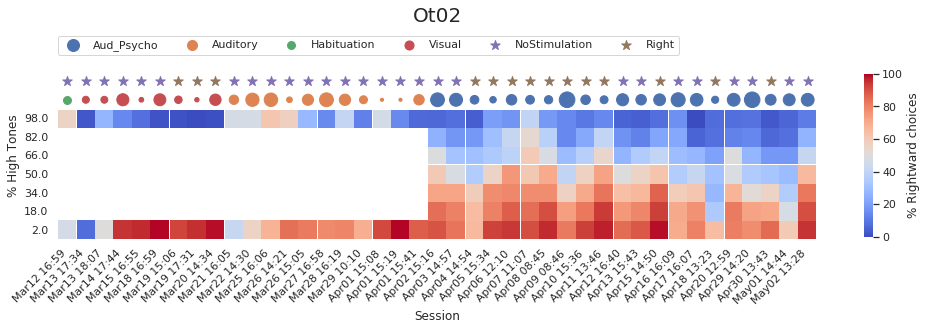

In [66]:
# plot it
sns.set(style="white")
fig, ax = plt.subplots(figsize=(17,5))
sns.heatmap(dfToPlot, linewidth=0.001, square=True, cmap="coolwarm",
            cbar_kws={"shrink": 0.6, 'label': '% Rightward choices'})
# label the number of trials and type of protocol
# TODO: check that the size is proportional (area vs radius)
# recalculate the number of trials as some might get grouped if they are on the same day. Do all below with the dataframe
Protocols = [pd.unique(AnimalDF[AnimalDF['SessionTime']==session]['Protocol'])[0] \
             for session in pd.unique(AnimalDF['SessionTime'])]
ntrialsDistribution = [len(AnimalDF[AnimalDF['SessionTime']==session]) for session in pd.unique(AnimalDF['SessionTime'])]
Stimulations = [pd.unique(AnimalDF[AnimalDF['SessionTime']==session]['Stimulation'])[0] \
             for session in pd.unique(AnimalDF['SessionTime'])]

for pr_counter, prot in enumerate(np.unique(Protocols)):
    protIdx = [i for i, x in enumerate(Protocols) if x == prot]
    ax.scatter([x + 0.5 for x in protIdx], np.repeat(len(difLevels)+0.5, len(protIdx)), marker='o',
               s=[ntrialsDistribution[x]/5 for x in protIdx], label = prot) 
# label the opto trials
for st_counter, stim in enumerate(np.unique(Stimulations)):
    stimIdx = [i for i, x in enumerate(Stimulations) if x == stim]
    ax.scatter([x + 0.5 for x in stimIdx], np.repeat(len(difLevels)+1.5, len(stimIdx)), marker='*', s=100, label = stim)
    
ax.legend(loc=(0,1.1), borderaxespad=0., ncol = pr_counter+st_counter+2, frameon=True)
ax.set_ylim([0, len(difLevels)+2])
plt.ylabel('% High Tones')
plt.xlabel('Session')
plt.yticks(rotation=0)
plt.xticks(horizontalalignment="right", rotation=45)
plt.title(AnimalID + '\n\n', fontsize=20, fontweight=0)
plt.savefig(outputDir + AnimalID + '_psychometricPerformanceAllSessionsHeatmap.pdf', transparent=True,
            dpi = 500, bbox_inches='tight')
plt.show(fig)

Progress: [####################] 100.0%


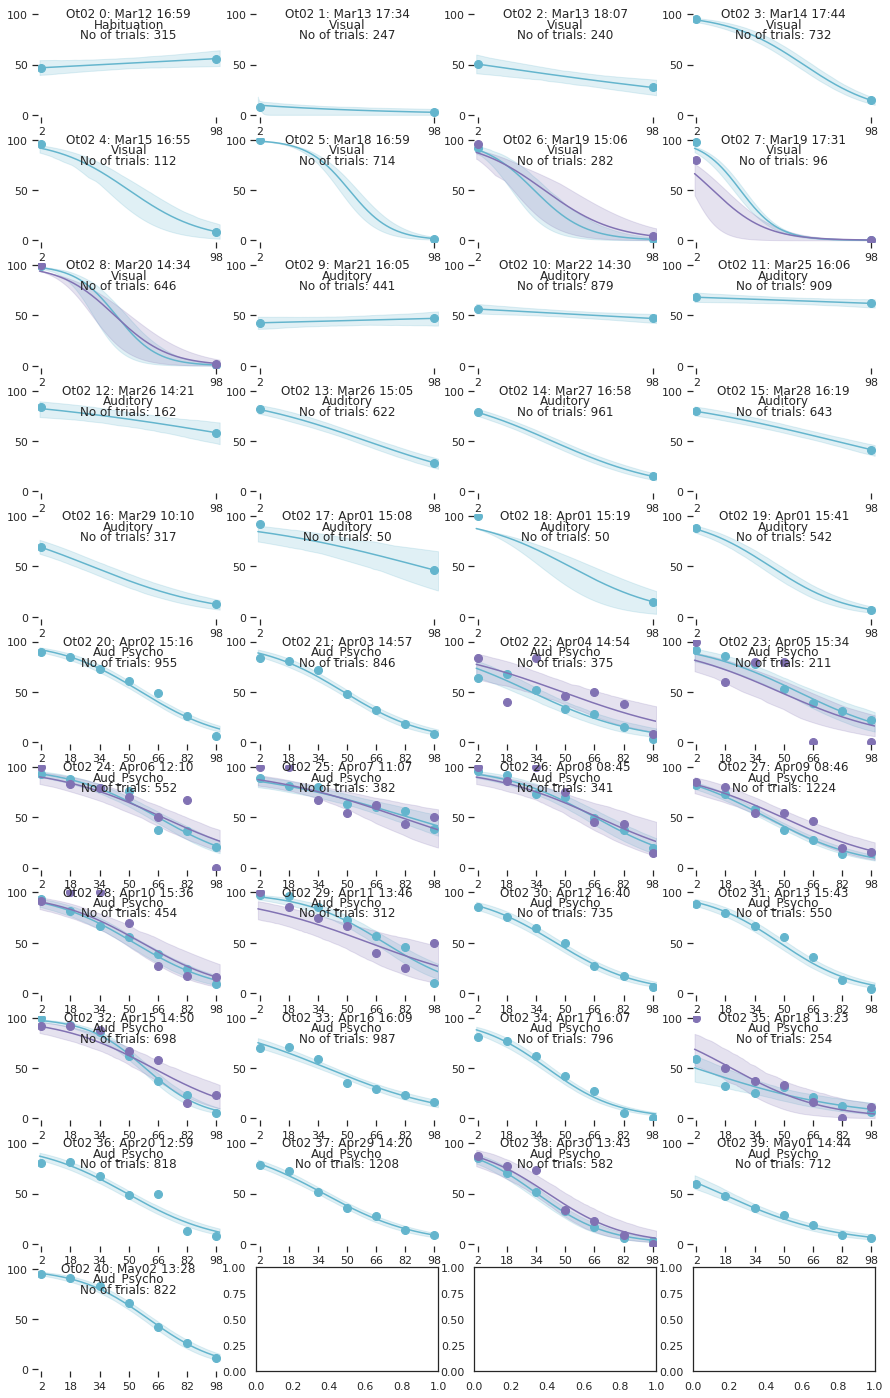

In [30]:
# Make a plot with the performance for all sessions MAKE THIS PRETTIER, CLEAN THIS AS BELOW

fig, axs = plt.subplots(math.ceil(len(pd.unique(AnimalDF['SessionTime']))/4), 4, figsize=(15, 25), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()


# process data from all experiments
for counter, session in enumerate(pd.unique(AnimalDF['SessionTime'])):    
    predictDif, Normal_PsyPer, Normal_fakePredictions, Normal_predictPer = \
    custom_functions.PP_ProcessExperiment(AnimalDF[(AnimalDF['SessionTime']==session) & (AnimalDF['OptoStim']==0)], 100)
    
    _, Opto_PsyPer, Opto_fakePredictions, Opto_predictPer = \
    custom_functions.PP_ProcessExperiment(AnimalDF[(AnimalDF['SessionTime']==session) & (AnimalDF['OptoStim']==1)], 100)
    
    if Normal_PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = Normal_PsyPer['Difficulty'], dataPerf = Normal_PsyPer['Performance'],
                         predictDif = predictDif, ax = axs[counter], fakePred = Normal_fakePredictions,
                         realPred = Normal_predictPer, color = 'c', label = 'normal')

    if Opto_PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = Opto_PsyPer['Difficulty'], dataPerf = Opto_PsyPer['Performance'],
                             predictDif = predictDif, ax = axs[counter], fakePred = Opto_fakePredictions,
                             realPred = Opto_predictPer, color = 'm', label = 'opto')
        
    axs[counter].get_legend().remove()
    axs[counter].text(.5,.95, AnimalID + ' ' + str(counter) + ': ' + str(session), \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.85, Protocols[counter] , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.75, 'No of trials: ' + str(ntrialsDistribution[counter]) , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].set_ylabel('')
    axs[counter].set_xlabel('')

    update_progress(counter / len(pd.unique(AnimalDF['SessionTime'])))
    
update_progress(1)
plt.savefig(outputDir + AnimalID + '_psychometricPerformanceAllSessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

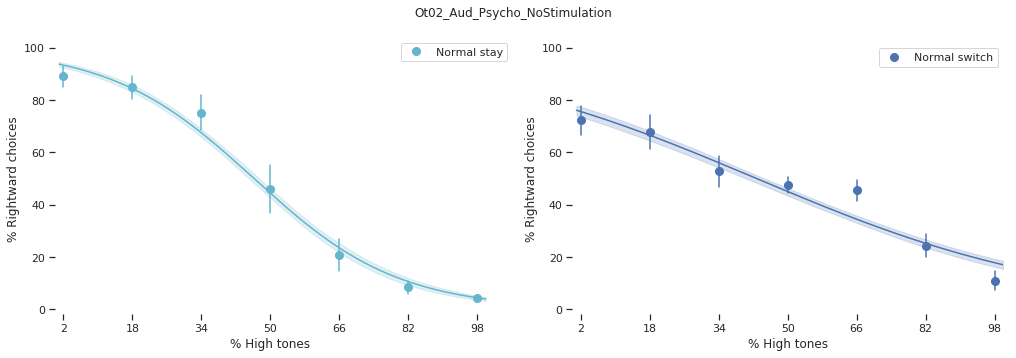

In [72]:
# Group sessions by type and plot them together
protToGroup = 'Aud_Psycho'
stimToGroup = 'NoStimulation'
pulledData = AnimalDF[(AnimalDF['Protocol']==protToGroup) & (AnimalDF['Stimulation']==stimToGroup)]
# provide an option to select by session TODO!

# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==1) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==0) & (pulledData['SwitchSide']==1),
            (pulledData['OptoStim']==1) & (pulledData['SwitchSide']==1)]
ColorList = ['c', 'm', 'b', 'r']
LabelList = ['Normal stay', 'Opto stay', 'Normal switch', 'Opto switch']

# plot
fig, axs = plt.subplots(1,2,figsize=(17, 5), facecolor='w', edgecolor='k')
axs.ravel()
AxsOrder = [0,0,1,1]
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB = \
    custom_functions.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)

lgd = plt.legend()
plt.suptitle(AnimalID + '_' + protToGroup + '_' + stimToGroup)

plt.savefig(outputDir + AnimalID + '_' + protToGroup + '_' + stimToGroup + '_grouped_psychometricPerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show(fig)

In [68]:
PsyPer

{'Difficulty': array([ 2., 18., 34., 50., 66., 82., 98.]),
 'Logit': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'Performance': array([89.1025641 , 84.86394558, 75.04393673, 46.00301659, 20.58823529,
         8.33333333,  4.41898527])}

In [64]:
EB

[15.40285233349109,
 23.480540587891316,
 23.76766060485315,
 35.966901425664304,
 32.24699631283416,
 21.356442760728914,
 22.17745213304266]

Text(0.5,0.98,'Ot02_Aud_Psycho_Right')

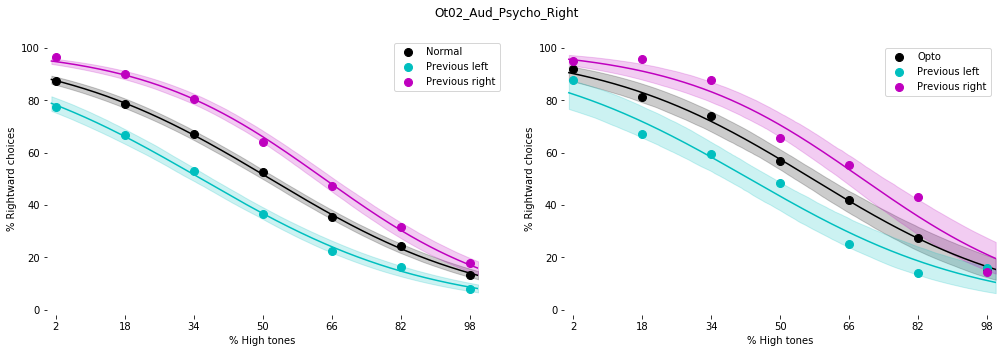

In [11]:
# Do the same for trials where the mouse has chosen the right or the left in the previous trial

# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==0) & (pulledData['PreviousChoice']==1),
            (pulledData['OptoStim']==0) & (pulledData['PreviousChoice']==2),
            (pulledData['OptoStim']==1),
            (pulledData['OptoStim']==1) & (pulledData['PreviousChoice']==1),
            (pulledData['OptoStim']==1) & (pulledData['PreviousChoice']==2)]
ColorList = ['k', 'c', 'm', 'k', 'c', 'm']
LabelList = ['Normal', 'Previous left', 'Previous right', 'Opto', 'Previous left', 'Previous right']

fig, axs = plt.subplots(1,2,figsize=(17, 5), facecolor='w', edgecolor='k')
axs.ravel()
AxsOrder = [0,0,0,1,1,1]

for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer = custom_functions.PP_ProcessExperiment(pulledData[condition], 100)
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i])

lgd = plt.legend()
plt.suptitle(AnimalID + '_' + protToGroup + '_' + stimToGroup)

Text(0.5,0.98,'Ot02_Aud_Psycho_Right')

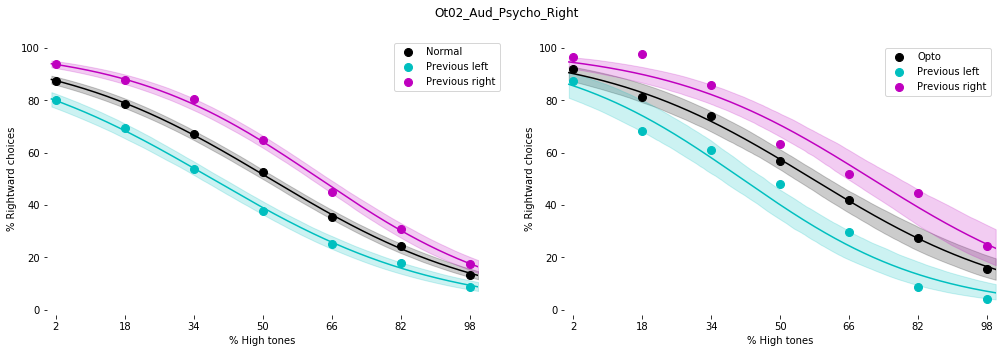

In [19]:
# Do the same for trials where the PREVIOUS TRIAL was left or right

PrevTrialSide = np.insert(np.array(pulledData['TrialSide'][:-1]), 0, np.nan)

# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==0) & (PrevTrialSide==1),
            (pulledData['OptoStim']==0) & (PrevTrialSide==2),
            (pulledData['OptoStim']==1),
            (pulledData['OptoStim']==1) & (PrevTrialSide==1),
            (pulledData['OptoStim']==1) & (PrevTrialSide==2)]
ColorList = ['k', 'c', 'm', 'k', 'c', 'm']
LabelList = ['Normal', 'Previous left', 'Previous right', 'Opto', 'Previous left', 'Previous right']

fig, axs = plt.subplots(1,2,figsize=(17, 5), facecolor='w', edgecolor='k')
axs.ravel()
AxsOrder = [0,0,0,1,1,1]

for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer = custom_functions.PP_ProcessExperiment(pulledData[condition], 100)
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i])

lgd = plt.legend()
plt.suptitle(AnimalID + '_' + protToGroup + '_' + stimToGroup)

In [59]:
predictDif, PsyPer, fakePredictions, predictPer, EB = custom_functions.PP_ProcessExperiment(pulledData[condition], error_bars='SessionTime')

In [60]:
EB

[15.40285233349109,
 23.480540587891316,
 23.76766060485315,
 35.966901425664304,
 32.24699631283416,
 21.356442760728914,
 22.17745213304266]

In [5]:
# SEND MAXIME THE DATA FOR THE PURPLE!
SD = pulledData[(pulledData['OptoStim']==1) & (pulledData['SwitchSide']==0)]

In [6]:
diffs = np.array(SD['TrialHighPerc'])
choices = np.array(SD['FirstPoke'])

In [7]:
nan_mask = ~(np.isnan(diffs) | np.isnan(choices))

In [9]:
dset = pd.DataFrame({'Difficulty': diffs[nan_mask],
                      'Choice': choices[nan_mask]})

      fun: 0.5026238868175102
 hess_inv: array([[ 2.47842365e+00, -3.70921102e-01,  5.20215616e+02,
        -2.60078547e+04],
       [-3.70921063e-01,  3.91814274e+00, -4.78888034e+02,
         2.39477723e+04],
       [ 5.20215520e+02, -4.78887805e+02,  1.07110951e+07,
        -5.35556578e+08],
       [-2.60078499e+04,  2.39477609e+04, -5.35556579e+08,
         2.67779201e+10]])
      jac: array([ 1.35440297e-06, -1.04750360e-06,  6.57961375e-06,  1.31633227e-07])
  message: 'Optimization terminated successfully.'
     nfev: 139
      nit: 73
     njev: 138
   status: 0
  success: True
        x: array([ -1.19551204,   0.62593582,   1.21725353, -60.52085643])


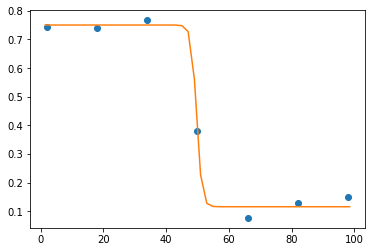

In [11]:
X = np.array(dset.Difficulty)
y_data = dset.groupby('Difficulty').agg(lambda x: np.mean(x == 2))
y = np.array(dset.Choice == 2)

# fit the model parameters and print optimization results
params, res = Lapse_model.fit_lapse_model(X, y)
print(res)

# display results
plt.figure()
plt.plot(y_data, 'o')
xs = np.linspace(min(X) - 0.5, max(X) + 0.5)
plt.plot(xs, Lapse_model.predict_lapse_model(xs, *params))
plt.show()


In [17]:
res

      fun: 0.5026238868175102
 hess_inv: array([[ 2.47842365e+00, -3.70921102e-01,  5.20215616e+02,
        -2.60078547e+04],
       [-3.70921063e-01,  3.91814274e+00, -4.78888034e+02,
         2.39477723e+04],
       [ 5.20215520e+02, -4.78887805e+02,  1.07110951e+07,
        -5.35556578e+08],
       [-2.60078499e+04,  2.39477609e+04, -5.35556579e+08,
         2.67779201e+10]])
      jac: array([ 1.35440297e-06, -1.04750360e-06,  6.57961375e-06,  1.31633227e-07])
  message: 'Optimization terminated successfully.'
     nfev: 139
      nit: 73
     njev: 138
   status: 0
  success: True
        x: array([ -1.19551204,   0.62593582,   1.21725353, -60.52085643])

In [93]:
# TODO:
# Remove trials when the animal is not engaged

# Explore deeply differences with the opto trials (e.g. if they poke more often in the center)



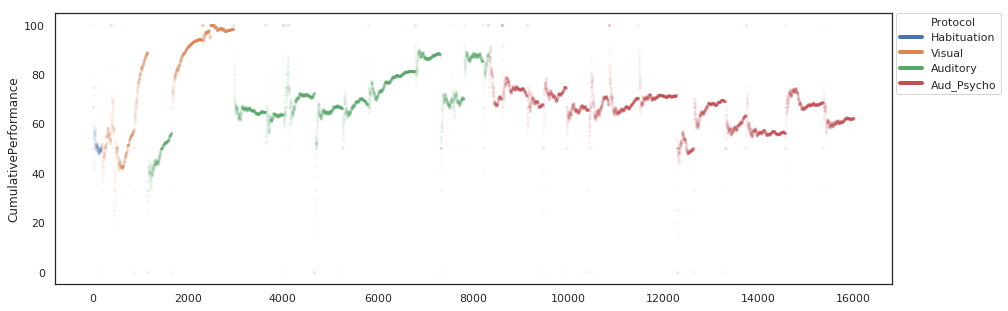

In [94]:
# plot the evolution of the cumulative performance
# TODO: include only the easy trials
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x = AnimalDF.index, y = 'CumulativePerformance', data=AnimalDF, hue = 'Protocol',
             marker=".", alpha = 0.05, markeredgewidth=0, linewidth=0)

lgd = plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(4)

plt.savefig(outputDir + AnimalID + '_CumulativePerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [95]:
# Separate between trials that are ocurring in a row and those that the animal has to switch (repetitive vs new side)
dfForBP = custom_functions.AnalyzeSwitchTrials(AnimalDF)

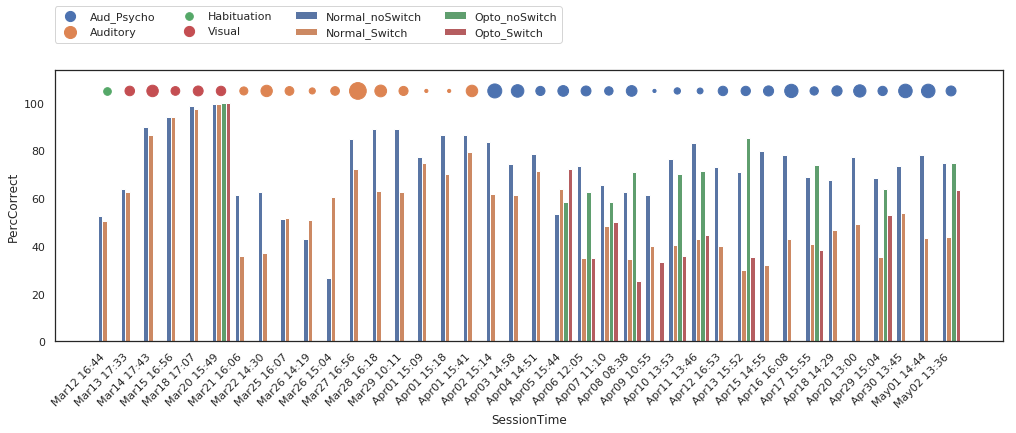

In [70]:
fig, ax = plt.subplots(figsize=(17,5))
sns.barplot(x='SessionTime', y='PercCorrect', hue='Condition', data=dfForBP)
# label the type of trials
for pr_counter, prot in enumerate(np.unique(Protocols)):
    protIdx = [i for i, x in enumerate(Protocols) if x == prot]
    ax.scatter([x for x in protIdx], np.repeat(105, len(protIdx)), marker='o',
               s=[ntrialsDistribution[x]/5 for x in protIdx], label = prot) 
lgd = plt.legend(loc=(0,1.1), borderaxespad=0., ncol = 4, frameon=True)
plt.xticks(horizontalalignment="right", rotation=45)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(1)
plt.show()




Go step by step: DEPRECATED. Go through and fix

In [ ]:
# select a session
x = 13

In [ ]:
# Split data into normal and opto trials
ExpNor, ExpOp = custom_functions.splitOpto(ExperimentData[x]['SessionData'])

In [ ]:
# Calculate psychometric performance parameters for each
Normal_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpNor['Difficulty'], sideSelected = ExpNor['SideSelected'])
Opto_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpOp['Difficulty'], sideSelected = ExpOp['SideSelected'])

In [ ]:
# predict data
predictDif = np.linspace(1, 100, 2000).reshape(-1, 1)

if Normal_PsyPer:
    Normal_predictPer = 100 * Normal_PsyPer['Logit'].predict_proba(predictDif)[:,1]
if Opto_PsyPer:
    Opto_predictPer = 100 * Opto_PsyPer['Logit'].predict_proba(predictDif)[:,1]

In [ ]:
# Bootstrap on fake data (generated inside the bootstrap function)
bootstrap_ntimes = 1000
np.random.seed(12233)  # fixed random seed for reproducibility

if Normal_PsyPer:
    Normal_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpNor['Difficulty'],
                                                                    sideSelected = ExpNor['SideSelected'],
                                                                    ntimes = bootstrap_ntimes,
                                                                    prediction_difficulties = predictDif)
if Opto_PsyPer:
    Opto_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpOp['Difficulty'],
                                                                    sideSelected = ExpOp['SideSelected'],
                                                                    ntimes = bootstrap_ntimes,
                                                                    prediction_difficulties = predictDif)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5, 5), facecolor='w', edgecolor='k')

if Normal_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Normal_PsyPer['Difficulty'], dataPerf = Normal_PsyPer['Performance'],
                     predictDif = predictDif, ax = axs, fakePred = Normal_fakePredictions,
                     realPred = Normal_predictPer, color = 'c', label = 'normal')

if Opto_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Opto_PsyPer['Difficulty'], dataPerf = Opto_PsyPer['Performance'],
                         predictDif = predictDif, ax = axs, fakePred = Opto_fakePredictions,
                         realPred = Opto_predictPer, color = 'm', label = 'opto')
lgd = plt.legend()
plt.title(AnimalID + ' ' + str(x) + ': ' + ExperimentTimes[x])

plt.savefig(outputDir + AnimalID + '_' + ExperimentTimes[x] + '_psychometricPerformance.pdf', transparent=True,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show(fig)